In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
import sys
import math
from math import cos, sin, atan, pi
import scipy.stats
from scipy.stats import norm

In [2]:
class WE_PathPlanning(gym.Env):
    '''Creates the Stochastic Windy GridWorld Environment
       NOISE_CASE = 1: the noise is a scalar added to the wind tiles, i.e,
                       all wind tiles are changed by the same amount
       NOISE_CASE = 2: the noise is a vector added to the wind tiles, i.e,
                       wind tiles are changed by different amounts.
    '''
    def __init__(self, VELOCITY, StandardDev_W, GRID_HEIGHT=7, GRID_WIDTH=7,\
                 START_STATE = (6,0), GOAL_STATE = (0, 5)):
                                                              
                                                              
        self.seed()
        self.grid_height = GRID_HEIGHT
        self.grid_width = GRID_WIDTH
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.v = VELOCITY
        self.sig_w = StandardDev_W
        # self.h_angle = HEAD_ANGLE
        self.observation = START_STATE
        
        self.actions = { 'E':0,    
                         'NE':1,   
                         'N':2,   
                         'NW':3,   
                         'W':4,
                         'SW':5,  
                         'S':6,  
                         'SE':7 }
        self.world = [
                      [(0,0),(0,1),(0,2),(0,3),(0,4),(0,5),(0,6)],
                      [(1,0),(1,1),(1,2),(1,3),(1,4),(1,5),(1,6)],
                      [(2,0),(2,1),(2,2),(2,3),(2,4),(2,5),(2,6)],
                      [(3,0),(3,1),(3,2),(3,3),(3,4),(3,5),(3,6)],
                      [(4,0),(4,1),(4,2),(4,3),(4,4),(4,5),(4,6)],
                      [(5,0),(5,1),(5,2),(5,3),(5,4),(5,5),(5,6)],
                      [(6,0),(6,1),(6,2),(6,3),(6,4),(6,5),(6,6)]
                     ]
        self.history = [START_STATE]        
    
    def wind_field():  # NEED TO SCALE TO (5,15)
        x, y = np.meshgrid(np.arange(7),np.arange(7))
        u = -y/np.sqrt(x**2 + y**2)   # X-component of the vector
        v = x/(x**2 + y**2)           # Y-component of the vector
        # u[i, j] to get X component of the grid at ith row & jth column 
        return u, v
    
    def transition_probs(self, state, action, next_state):
        actions = ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
        actions_angles = {}
        for i in range(8):
          if i == 0:
            actions_angles[actions[i]] = 0
          else:
            actions_angles[actions[i]] = actions_angles[actions[i-1]] + pi/4 

        i, j = state
        h_angle = actions_angles[action]    # h_angle = heading angle(psi)
        Fx = self.v * cos(h_angle) + float(u[i,j])      
        Fy = self.v * sin(h_angle) + float(v[i,j])
        w = atan(Fy/Fx)                     # w = omega- resultant vector angle

        def prob(theta):
            probability = norm(w, self.sig_w).cdf(theta + pi/8) - norm(w, self.sig_w).cdf(theta - pi/8)
            return probability

        p, q = next_state
        if abs(p - i) <= 1 and abs(q - j) <= 1 and (p, q) != (i, j):
          
            if (p,q) == (i,j+1):
              return prob(actions_angles['E'])

            elif (p,q) == (i-1,j+1):
              return prob(actions_angles['NE'])

            elif (p,q) == (i-1,j):
              return prob(actions_angles['N'])

            elif (p,q) == (i-1,j-1):
              return prob(actions_angles['NW'])

            elif (p,q) == (i,j-1):
              return prob(actions_angles['W'])

            elif (p,q) == (i+1,j-1):
              return prob(actions_angles['SW'])

            elif (p,q) == (i+1,j):
              return prob(actions_angles['S'])

            elif (p,q) == (i+1,j+1):
              return prob(actions_angles['SE'])  
        else:
          return 0

    def reward(self, state):
        if state == self.goal_state:
          return 100
        else:
          i, j = state
          target_vector = np.array(self.goal_state) - [i, j]
          tv_mag = np.linalg.norm(target_vector)
          wi = u[i][j] 
          wj = v[i][j]  
          numerator = np.dot(target_vector, [wi, wj])/tv_mag
          W_max = 15
          C = 30
          Reward = (numerator / W_max) * C
          return Reward
    
    def step(self, action):
        
        i, j = self.observation
        # [(i,j+1), (i-1,j+1), (i-1,j), (i-1,j-1), (i,j-1), (i+1,j-1), (i+1,j), (i+1,j+1)]

        if i == 0:
          if j == 0:
            next_state = [(i,j+1), (i+1,j), (i+1,j+1)]
          elif j == 6:
            next_state = [(i,j-1), (i+1,j-1), (i+1,j)]
          else:
            next_state = [(i,j+1), (i,j-1), (i+1,j-1), (i+1,j), (i+1,j+1)]

        elif i == 6:
          if j == 0:
            next_state = [(i,j+1), (i-1,j+1), (i-1,j)]
          elif j == 6:
            next_state = [(i-1,j), (i-1,j-1), (i,j-1)]
          else:
            next_state = [(i,j+1), (i-1,j+1), (i-1,j), (i-1,j-1), (i,j-1)]

        elif j == 0:
          next_state = [(i,j+1), (i-1,j+1), (i-1,j), (i+1,j), (i+1,j+1)]
        elif j == 6:
          next_state = [(i-1,j), (i-1,j-1), (i,j-1), (i+1,j-1), (i+1,j)]

        else:
          next_state = [(i,j+1), (i-1,j+1), (i-1,j), (i-1,j-1), (i,j-1), (i+1,j-1), (i+1,j), (i+1,j+1)]

        P = []
        for t in next_state:
          P.append(self.transition_probs(self.observation, action, t))
        arr = np.array(P)
        arr = arr/np.sum(arr)
        P = arr.tolist()


        next_state_map = {
                            'E': (i,j+1),
                            'NE': (i-1,j+1),
                            'N': (i-1,j),
                            'NW': (i-1,j-1),
                            'W': (i,j-1),
                            'SW': (i+1,j-1),
                            'S': (i+1,j),         
                            'SE': (i+1,j+1)
                         }

        rev_next_state_map = {
                              (i,j+1): 'E',
                              (i-1,j+1): 'NE',
                              (i-1,j): 'N',
                              (i-1,j-1): 'NW',
                              (i,j-1): 'W',
                              (i+1,j-1): 'SW',
                              (i+1,j): 'S',         
                              (i+1,j+1): 'SE'
                             }

        maps = []
        for s in next_state:
          maps.append(rev_next_state_map[s])
        
        trans_state = np.random.choice(maps, p=P)
        self.observation = next_state_map[trans_state]

        self.history.append(self.observation)
        
        if self.observation == self.goal_state:
            return self.observation, True  
        return self.observation, False     
          
    def reset(self):
        ''' resets the agent position back to the starting position'''
        self.observation = self.start_state
        return self.observation   

    def render(self, mode='human', close=False):
      
        outfile = sys.stdout
        nS = self.grid_height * self.grid_width
        shape = (self.grid_height, self. grid_width)

        outboard = ""
        for y in range(-1, self.grid_height + 1):
            outline = ""
            for x in range(-1, self.grid_width + 1):
                position = (y, x)
                if self.observation == position:
                    output = "X"
                elif position == self.goal_state:
                    output = "G"
                elif position == self.start_state:
                    output = "S"
                elif x in {-1, self.grid_width } or y in {-1, self.grid_height}:
                    output = "#"
                else:
                    output = " "

                if position[1] == shape[1]:
                    output += '\n'
                outline += output
            outboard += outline
        outboard += '\n'
        outfile.write(outboard)

        if len(self.history)>1:
            for i in range(len(self.history)-1):
                plt.plot([100*self.history[i][0]+50,100*self.history[i+1][0]+50],[100*self.history[i][1]+50,100*self.history[i+1][1]+50],color="black", linewidth=1)
        
        plt.grid(color="orange")
        plt.xticks(np.arange(0,100*self.grid_height+1,100),(np.arange(0,100*self.grid_width+1,100)/100).astype(np.int0))
        plt.yticks(np.arange(0,100*self.grid_height+1,100),(np.arange(0,100*self.grid_width+1,100)/100).astype(np.int0))
        plt.tick_params(axis='y', labelright=True,labelleft=False)
        plt.show()
        
    def seed(self, seed=None):
        ''' sets the seed for the envirnment'''
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [3]:
# NEED TO SCALE TO (5,15)
x, y = np.meshgrid(np.arange(7),np.arange(7))
u = -y/np.sqrt(x**2 + y**2)   # X-component of the vector
v = x/(x**2 + y**2) #+ 0.5      # Y-component of the vector
# u[i, j] to get X component of the grid at ith row & jth column 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [4]:
# x, y = np.meshgrid(np.arange(7),np.arange(7))

# u = 2*np.cos(y)
# v = np.sin(x)

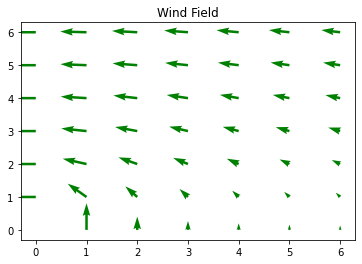

In [5]:
# Plotting Wind Field with QUIVER
plt.quiver(x, y, u, v, color='g')
plt.title('Wind Field')

# plt.grid()
plt.show()

In [6]:
agent = WE_PathPlanning(20, 1) #START_STATE = , GOAL_STATE = (1,6)

In [7]:
agent.world

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)],
 [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6)],
 [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]]

In [8]:
# states = np.zeros((7,7))

V = np.zeros((7,7))
PI = np.zeros((7,7))

max_iter = 10000  # Maximum number of iterations
delta = 10
gamma = 0.9

In [9]:
for k in range(max_iter):
    max_diff = 0  # Initialize max difference
    V_new = np.zeros((7,7))  # Initialize values
    for x in agent.world:
        for y in x:
            max_val = 0
            for a in agent.actions:

            # Compute state value
                val = agent.reward(y)  # Get direct reward
                for i in agent.world:
                    for j in i:
                        val += agent.transition_probs(y, a, j) * (gamma * V[j]) # Add discounted downstream values

            # Store value best action so far
                max_val = max(max_val, val)
                # print(max_val)
            # Update best policy
                if V_new[y] < val:
                    PI[y] = agent.actions[a]  # Store action with highest value

            V_new[y] = max_val  # Update value with highest value

        # Update maximum difference
            max_diff = max(max_diff, abs(V[y] - V_new[y]))

    # Update value functions
    V = V_new

    # If diff smaller than threshold delta for all states, algorithm terminates
    if max_diff < delta:
        break

In [10]:
print(V)

[[  0.           2.908055     3.30708596   8.65766712  29.11877367
  104.24126851   9.41879755]
 [  1.61294348   4.20599616   8.25875481  20.09464335  45.01910209
   43.43664863  27.88871734]
 [  2.45517542   5.49055602  11.89338438  23.07645277  29.76283774
   30.79040421  18.99941416]
 [  3.11924662   5.57546804  10.22839259  15.49892917  19.54552286
   18.9496148   11.95655002]
 [  3.66080938   4.9721704    6.41645141   8.28408048   9.65314449
    9.22348947   5.99400173]
 [  4.13150404   5.08338748   5.47046931   5.4186549    4.99143818
    4.19850081   2.82674321]
 [  4.54752467   5.48114026   5.86501449   5.84841255   5.48006447
    4.706801     3.20432532]]


In [11]:
print(PI)

[[0. 7. 7. 7. 7. 7. 6.]
 [7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7.]]


In [14]:
agent.reset()

(6, 0)

#########
#     G #
#       #
#       #
#       #
#       #
#       #
#X      #
#########



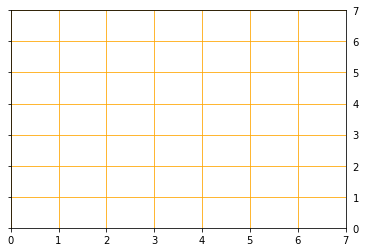

In [12]:
agent.render()

#########
#     G #
#       #
#       #
#       #
#       #
#       #
#SX     #
#########



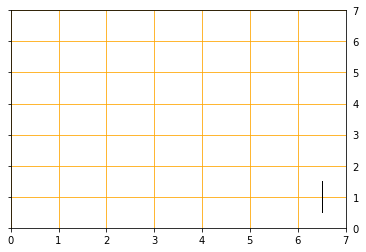

False
#########
#     G #
#       #
#       #
#       #
#       #
#       #
#S X    #
#########



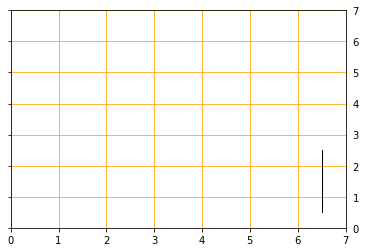

False
#########
#     G #
#       #
#       #
#       #
#       #
#   X   #
#S      #
#########



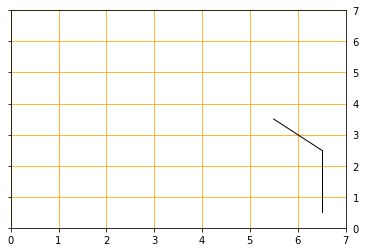

False
#########
#     G #
#       #
#       #
#       #
#    X  #
#       #
#S      #
#########



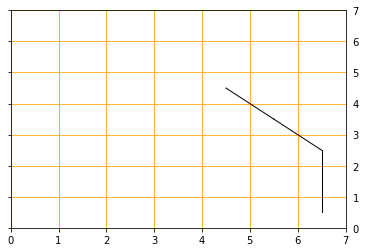

False
#########
#     G #
#       #
#       #
#       #
#     X #
#       #
#S      #
#########



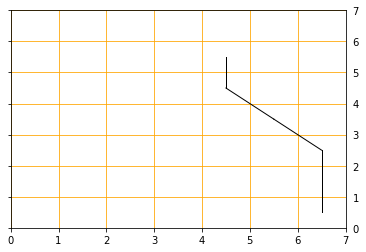

False
#########
#     G #
#       #
#       #
#      X#
#       #
#       #
#S      #
#########



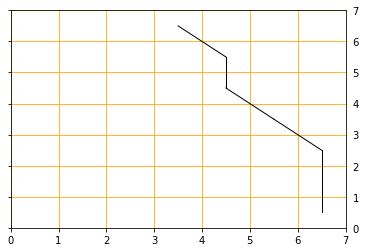

False
#########
#     G #
#       #
#      X#
#       #
#       #
#       #
#S      #
#########



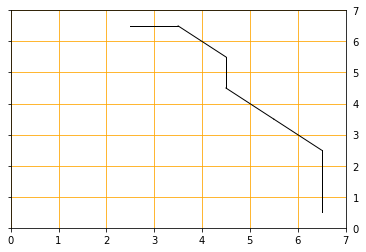

False
#########
#     G #
#      X#
#       #
#       #
#       #
#       #
#S      #
#########



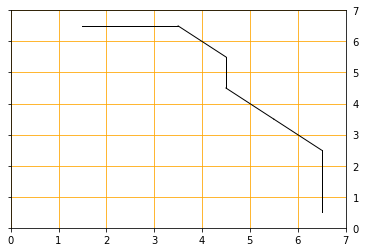

False
#########
#     X #
#       #
#       #
#       #
#       #
#       #
#S      #
#########



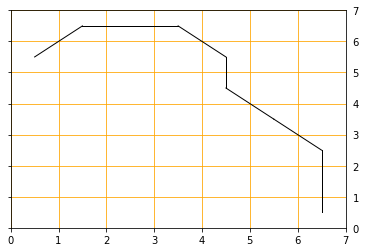

True


In [13]:
# def play_policy(env,policy):
action_rev = {
                            0:'E',
                            1:'NE',
                            2:'N',
                            3:'NW',
                            4:'W',
                            5:'SW',
                            6:'S',
                            7:'SE'
                  }        
s = agent.start_state
count=0
while True:
  action = PI[s[0],s[1]]
  a = action_rev[action]
  next_state, done = agent.step(a)
  s = next_state
  count+=1
  agent.render()
  print(done)

  if done or count==30:
      break
    
  